In [1]:
import os
import tensorflow as tf
import sklearn
import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, UpSampling2D, concatenate, Input, Cropping2D
from keras.models import Model
from keras.optimizers import Adam
import math
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from skimage.io import imread
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


## 1. Read images

In [2]:
TRAIN_IMG_PATH = 'banco_dados_SB/train/imagens/'
TRAIN_LBL_PATH = 'banco_dados_SB/train/classes/'

TEST_IMG_PATH = 'banco_dados_SB/test/imagens/'
TEST_LBL_PATH = 'banco_dados_SB/test/classes/'

In [3]:
X_train = [imread(fname=TRAIN_IMG_PATH + img, as_grey=True) for img in os.listdir(TRAIN_IMG_PATH)]
y_train = [imread(fname=TRAIN_LBL_PATH + lbl)[:, :, 0] for lbl in os.listdir(TRAIN_LBL_PATH)]
X_test = [imread(fname=TEST_IMG_PATH + img, as_grey=True) for img in os.listdir(TEST_IMG_PATH)]
y_test = [imread(fname=TEST_LBL_PATH + lbl)[:, :, 0] for lbl in os.listdir(TEST_LBL_PATH)]

## 2. Prepare Data

In [4]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
mean = np.mean (X_train) # tirando a media das imagens de treinamento
std = np.std (X_train) # normalizando a imagem de treinamento
X_train -= mean
X_train /= std

In [5]:
# preparando X_test, verificar que se usa a mesma media e desvio padrão obtidos com as imagens de treinamento
X_test = np.asarray(X_test)
y_test = np.asarray (y_test)
X_test -= mean
X_test /= std

In [6]:
print ('X_train shape = {0} and y_train shape = {1} '.format (X_train.shape ,y_train.shape))
print ('X_test shape  = {0}  and y_test shape  = {1} '.format (X_test.shape ,y_test.shape))

X_train shape = (338, 256, 256) and y_train shape = (338, 256, 256) 
X_test shape  = (82, 256, 256)  and y_test shape  = (82, 256, 256) 


## 3. Definindo função Dice

In [7]:
def dice_coef(y_true, y_pred, smooth=0.0):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=10.0)


## 4. Dividindo as amostras entre conjunto de treino e validation

In [8]:
print ('Maior numero label train: ',np.max(y_train))
print ('Menor numero label train: ',np.min(y_train))

Maior numero label train:  2
Menor numero label train:  0


In [9]:
bounds = int(len(X_train)-(np.floor(338*.1)))
print (bounds)
X_validate = X_train[bounds:,:,:]
y_validate = y_train[bounds:,:,:]
X_train = X_train[:bounds,:,:]
y_train = y_train[:bounds,:,:]
print(X_validate.shape,y_validate.shape )
print(X_train.shape,y_train.shape )
print ('Maior numero label train: ',np.max(y_train))
print ('Menor numero label train: ',np.min(y_train))

305
(33, 256, 256) (33, 256, 256)
(305, 256, 256) (305, 256, 256)
Maior numero label train:  2
Menor numero label train:  0


## 5. Testing data set

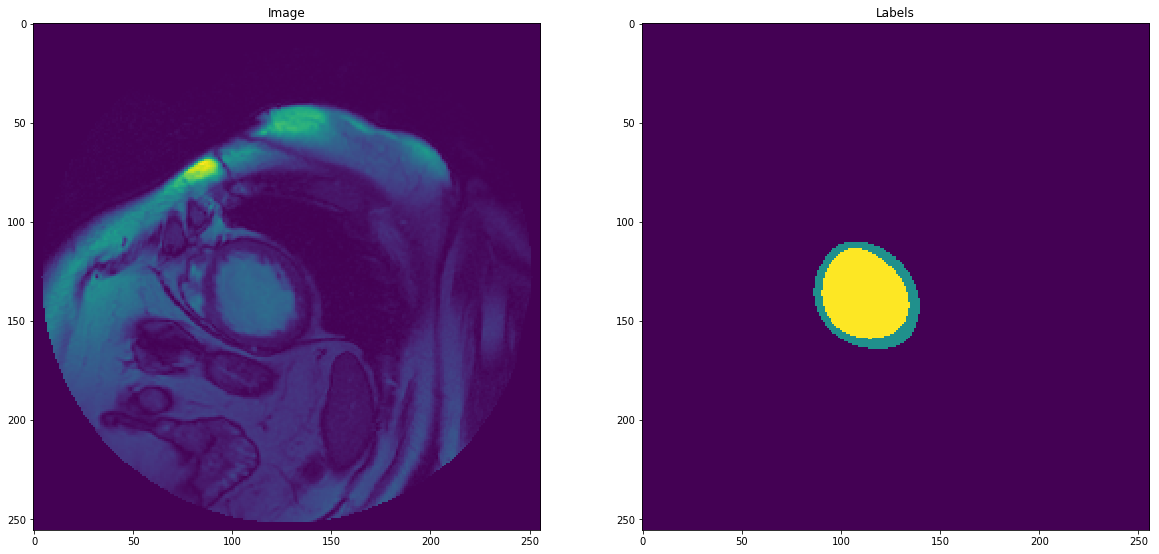

In [10]:
idx = 145

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X_train[idx])
ax[0].set_title('Image')

ax[1].imshow(y_train[idx])
ax[1].set_title('Labels')

plt.show()

## 6. Create CNN model

In [11]:
class Unet_LIS(object):

    def __init__(self, img_rows , img_cols):
        self.img_rows = img_rows
        self.img_cols = img_cols
            
    def get_unet(self):

        inputs = Input((self.img_rows, self.img_cols,1))
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
        
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)
        
        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
        
        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
        
        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8],axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
        
        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1,up9],axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(1, 3, activation = 'sigmoid', padding = 'same')(conv9)
        model = Model(input = inputs, output = conv10)

        model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = ['accuracy',dice_coef])

        return model

In [12]:
myunet = Unet_LIS(X_train[0].shape[0],X_train[0].shape[1])
model = myunet.get_unet()

C:\Users\pd07\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [13]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 64)  640         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 256, 256, 64)  36928       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 128, 128, 64)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________

## 7. Prepare data

In [14]:
# Reshape input images to fit TensorFlow shape pattern
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_validate = X_validate.reshape(X_validate.shape[0], X_validate.shape[1], X_validate.shape[2], 1)
y_validate = y_validate.reshape(y_validate.shape[0], y_validate.shape[1], y_validate.shape[2], 1)

## 8. Train model

In [15]:
from keras.models import load_model
savings = "./savings_UNet3L_ZM_1"
if os.path.isdir(savings):
    path_sav = "savings_UNet3L_ZM_1/"
    model.load_weights(path_sav +'U_net_ZM_1.h5')
    print('Rede iniciando de onde parou')

Rede iniciando de onde parou


In [16]:
batch_size = 16
epochs = 30
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph_3L', histogram_freq=0,  
          write_graph=True, write_images=True,batch_size=batch_size)

# Monitorando se a função não esta aprendendo mais...
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_validate, y_validate),
          callbacks=[tbCallBack,early_stopping])

Train on 305 samples, validate on 33 samples
Epoch 1/30
305/305 [==============================] - 1640s - loss: -0.1371 - acc: 0.9760 - dice_coef: 1.1370 - val_loss: -0.0233 - val_acc: 0.9746 - val_dice_coef: 1.0228
Epoch 2/30
305/305 [==============================] - 1627s - loss: -0.1385 - acc: 0.9759 - dice_coef: 1.1385 - val_loss: -0.0127 - val_acc: 0.9777 - val_dice_coef: 1.0113
Epoch 3/30
305/305 [==============================] - 1639s - loss: -0.0983 - acc: 0.9739 - dice_coef: 1.0982 - val_loss: 0.0110 - val_acc: 0.9718 - val_dice_coef: 0.9887
Epoch 4/30
305/305 [==============================] - 1625s - loss: -0.1482 - acc: 0.9760 - dice_coef: 1.1483 - val_loss: -0.0925 - val_acc: 0.9793 - val_dice_coef: 1.0909
Epoch 5/30
305/305 [==============================] - 1629s - loss: -0.1584 - acc: 0.9770 - dice_coef: 1.1584 - val_loss: -0.0707 - val_acc: 0.9782 - val_dice_coef: 1.0701
Epoch 6/30
305/305 [==============================] - 1627s - loss: -0.1662 - acc: 0.9767 - dice

In [17]:
if not os.path.isdir('savings_UNet3L_ZM_1'):
    path_sav = "savings_UNet3L_ZM_1/"
    os.makedirs(path_sav)
model.save_weights(path_sav +'U_net_ZM_1.h5')

In [18]:
P_fig = model.predict(X_test, batch_size=batch_size, verbose=1)

82/82 [==============================] - 129s   


## 9. Transformando para valores inteiros imagem teste predict

In [19]:
#  Ao converter de valores float para inteiros vc tem o valor final da imagem aproximado
# como se fosse o valor mais proximo daquele número previsto
P_fig.shape
im_final = P_fig.astype ('uint8')
im_teste= np.round(P_fig).astype('uint8')
im_final = np.squeeze(im_final)
im_teste = np.squeeze(im_teste)
print('Maximo número im_teste: ',np.max(im_teste)) # arredondado pelo np.round
print('Maximo número im_final: ',np.max(im_final)) # arredondado diretamente por .astype('uint8')
im_final.shape

Maximo número im_teste:  1
Maximo número im_final:  1


(82, 256, 256)

Text(0.5,1,'Imagem final')

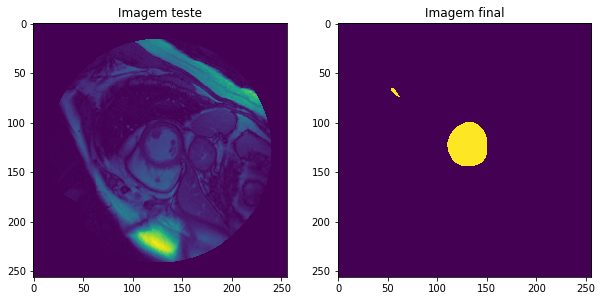

In [23]:
idx = 7

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(X_test[idx,:,:,0])
ax[0].set_title('Imagem teste')

ax[1].imshow(im_final[idx,:,:])
ax[1].set_title('Imagem final')

In [21]:
sess = tf.Session()
writer = tf.summary.FileWriter("Graph_3L_ZM_1")
writer.add_graph (sess.graph)
sess.close()